# Scientific Articles Metadata Dataset

__Detailed Metadata on Scholarly Articles for Research and Analysis__

_Description:_  
This dataset includes detailed metadata on scientific articles, featuring titles, authors, and publication dates.   
It's perfect for bibliometric analysis, citation network studies, and tracking research trends. Ideal for researchers and analysts seeking valuable insights into scholarly works, and for beginners to practice Exploratory Data Analysis.  

For more details on dataset source, see READ-ME file (scientific_papers_metadata_20240709_READ_ME.txt).

_Data File:_  
scientific_papers_metadata_20240709.csv


## 1/ Getting ready to analyse the data
NOTE: Also use a spreadsheet editor (MS Excel, Google Docs, OpenOffice, etc...) to view the raw data and assess what needs to be done.

### 1.1/ Loading Python libraries

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import gensim
from gensim.parsing.preprocessing import preprocess_string
from gensim import corpora
from gensim.models import LdaModel

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords') # once downloaded, comment this line to avoid warning message
# nltk.download('punkt') # once downloaded, comment this line to avoid warning message
# nltk.download('wordnet') # once downloaded, comment this line to avoid warning message


import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from scipy import stats
from scipy.stats import sem
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image

from joblib import Parallel, delayed
import multiprocessing
from collections import Counter
import squarify

from tqdm import tqdm
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)  # Disable column wrapping when using the "display" command



### 1.2/ Loading and inspection the raw data

In [3]:
# load and inspect data
df = pd.read_csv('scientific_papers_metadata_20240709.csv')
print('Dimension of df: ', df.shape) # (120000, 16)
print('Headers of df: ', df.columns) 
# ['DOI','title','author','issued','abstract','publisher','container-title','volume','issue','URL','score','references-count','language','subject','type','indexed']
print("Variable types of df:")
print(df.dtypes)
print("Summary statistics of df:")
print(df.describe())
# print("Missing values of df:")
# print(df.isna().value_counts()) # lots of missing values
display(df.head(2))

Dimension of df:  (120000, 16)
Headers of df:  Index(['DOI', 'title', 'author', 'issued', 'abstract', 'publisher',
       'container-title', 'volume', 'issue', 'URL', 'score',
       'references-count', 'language', 'subject', 'type', 'indexed'],
      dtype='object')
Variable types of df:
DOI                  object
title                object
author               object
issued               object
abstract             object
publisher            object
container-title      object
volume               object
issue                object
URL                  object
score               float64
references-count      int64
language             object
subject              object
type                 object
indexed              object
dtype: object
Summary statistics of df:
          score  references-count
count  120000.0     120000.000000
mean        0.0         13.675583
std         0.0         21.945725
min         0.0          0.000000
25%         0.0          0.000000
50%         0.0   

DOI                                              title            author  issued abstract           publisher                                  container-title volume issue                                          URL  score  references-count language                                            subject             type     indexed
0  10.1080/15326349508807347  Computing erlang–b function derivatives in the...  Jorge Sá Esteves  1995-1      NaN  Informa UK Limited  Communications in Statistics. Stochastic Models     11     2  http://dx.doi.org/10.1080/15326349508807347    0.0                22       en                            Modeling and Simulation  journal-article  2022-04-06
1  10.1080/02642068700000008         The Customer Service and Quality Challenge  David A. Collier  1987-1      NaN  Informa UK Limited                   The Service Industries Journal      7     1  http://dx.doi.org/10.1080/02642068700000008    0.0                11       en  Management of Technology and Innovation, Strat...  journal-article  2022-04-06

### 1.3/ Assessing variables  
Below are listed all the variables and what they are:  
- DOI: Digital Object Identifier, the unique ID of a publication
- title: Title of the article
- author: Name of first author
- issued: Date of publication
- abstract: Abstract of the article
- publisher: Publisher of the scientific journal
- container-title: Name of the scientific journal
- volume: Volume number of the scientific journal
- issue: Issue number of the scientific journal
- URL: URL of DOI
- score: I don't know what that is but it doesn't matter as it's always 0
- references-count: Number of references used in the article
- language: Language used in the article (2 letters abbreviations)
- subject: Subject of the article
- type: Type of article
- indexed: Date of article indexing  

Not all of the variables are relevant, therefore I will subset the data to keep only the informative columns


## 2/ Data Wrangling and Cleaning  
There are lots of columns that will need wrangling and cleaning:  
- DOI: looks fine, keep as it is
- title: missing values, capital letters, special characters, non sensical words, incomplete title, date instead of title etc... Maybe I don't need to use them.
- author: missing values, inconsistent format (inconcistent use of separators, capitalisation, first name initialed, etc...)
- issued: the dates formats are varied, needs to be uniformised. Years, months, days should be extracted
- abstract: mostly missing values, don't use 
- publisher: looks fine, keep as it is
- container-title: rename header as 'journal', otherwise it looks fine, keep as it is
- volume: inconsistent format (numbers, letters, dates), maybe I don't need to use them.
- issue: inconsistent format (numbers, letters, dates), maybe I don't need to use them.
- URL: redundant information with DOI, can be ignored or removed
- score: always 0, can be ignored or removed
- references-count: looks fine, keep as it is (integers)
- language: missing values but otherwise it looks fine, keep as it is
- subject: missing values but otherwise it looks fine, keep as it is
- type: looks fine, keep as it is 
- indexed: looks fine, keep as it is (dates from 2022-2023). Not sure how relevant it is, maybe I don't need to use them.  


## 2.1/ Subsetting the data
for the reasons explained above, I will only keep the following columns:
- DOI: KEEP (can be used as an index as they are unique identifiers)
- title: KEEP
- author: KEEP
- issued: KEEP
- abstract: REMOVE
- publisher: KEEP
- container-title: KEEP
- volume: REMOVE
- issue: REMOVE
- URL: REMOVE
- score: REMOVE
- references-count: KEEP
- language: KEEP
- subject: KEEP
- type: KEEP
- indexed: REMOVE

In [5]:
# Creating a copy of the subset DataFrame
df1 = df[['DOI','title','author','issued','publisher','container-title','references-count','language','subject','type']].copy()
# Renaming column in the copy
df1.rename(columns={'container-title': 'journal'}, inplace=True)
display(df1.head(2))

DOI                                              title            author  issued           publisher                                          journal  references-count language                                            subject             type
0  10.1080/15326349508807347  Computing erlang–b function derivatives in the...  Jorge Sá Esteves  1995-1  Informa UK Limited  Communications in Statistics. Stochastic Models                22       en                            Modeling and Simulation  journal-article
1  10.1080/02642068700000008         The Customer Service and Quality Challenge  David A. Collier  1987-1  Informa UK Limited                   The Service Industries Journal                11       en  Management of Technology and Innovation, Strat...  journal-article

### 2.2/ Handling date formats in 'issued'
I will first fix the following variable:  
__issued__  the dates formats are varied, needs to be uniformised. Years, months, days should be extracted.  
The various formats are:  
- yyyy-mm
- yyyy
- dd/mm/yyyy
- None  

I use `pd.to_datetime` to convert the 'issued' column to a consistent datetime format, and store it in a new column 'publication_date'. 
However, this will only keep dd/mm/yyyy and yyyy-mm (the latter will have 01 as dd). I will loose yyyy entries.  
I also create another column caputring the issued year in a new column 'publication_year'.

In [7]:
# Converting 'issued' to datetime and storing it in 'publication_date'
df1['publication_date'] = pd.to_datetime(df1['issued'], errors='coerce') # `errors='coerce'` handles any parsing errors by setting the problematic entries to NaT (Not a Time)

# Extracting the year (yyyy) and storing in 'publication_year'
df1['publication_year'] = df1['issued'].str.extract(r'\b(\d{4})\b')

# Convert year to integer, keeping NaN values
df1['publication_year'] = df1['publication_year'].astype('Int64')

# Display the DataFrame with the new 'publication_date' variable
display(df1.head(2))

# Checking if all year entries are accounted for -- yes they are
print(df.issued.isna().value_counts()) # 1334 missing values
print(df1.publication_year.isna().value_counts()) # 1334 missing values


DOI                                              title            author  issued           publisher                                          journal  references-count language                                            subject             type publication_date  publication_year
0  10.1080/15326349508807347  Computing erlang–b function derivatives in the...  Jorge Sá Esteves  1995-1  Informa UK Limited  Communications in Statistics. Stochastic Models                22       en                            Modeling and Simulation  journal-article       1995-01-01              1995
1  10.1080/02642068700000008         The Customer Service and Quality Challenge  David A. Collier  1987-1  Informa UK Limited                   The Service Industries Journal                11       en  Management of Technology and Innovation, Strat...  journal-article       1987-01-01              1987

issued
False    118666
True       1334
Name: count, dtype: int64
publication_year
False    118666
True       1334
Name: count, dtype: int64


### 2.3/ Handling name formats in 'author'
I will then fix the following variable:
__author__ the order of the first and last names in inconsistent, so is the format (inconcistent use of separators).
The various formats are:  
- First M; Last
- First M. Last
- F. M. Last
- FIRST LAST
- First LAST
- some names contain special character

The last names are always the last words of the entry.  
I use `str.extract` to extract the last word from the 'author' column and store it in a new column 'first_author'.   

In [9]:
# Extracting the last word of the author's name and storing in 'first_author'
df1['author_lastname'] = df1['author'].str.split().str[-1]

# Display the DataFrame with the new 'first_author' variable
display(df1[['author','author_lastname']])

author author_lastname
0       Jorge Sá Esteves         Esteves
1       David A. Collier         Collier
2          F.-G. Kirscht         Kirscht
3              S. A. Beg             Beg
4             M. Kittler         Kittler
...                  ...             ...
119995               NaN             NaN
119996     G. T. Stevens         Stevens
119997     Martin Conboy          Conboy
119998        K. H. Jost            Jost
119999               NaN             NaN

[120000 rows x 2 columns]

### 2.4/ Handling text formats in 'title'
I will now fix the following variable:
__title__  lots of issues: 

- missing values 
- capital letters 
- special characters 
- non sensical/not english words 
- incomplete title
- date instead of title
- numbers instead of title
- article type instead of title
- etc... 

Handling the uniformization of the `title` variable with the listed issues requires a multi-step approach.  
The first thing to do is to remove rows with no authors as they do not correspond to real scientific articles.  
That will also get rid of dates and numbers as well as some of the missing values.  
Then, I will copy the titles into a new column 'better_title' and convert to lower case and remove special characters.  
Some of the article type could be used for the analysis (e.g. erratum, addendum, editorial, etc...).   
For the incomplete titles, non sensical/not english words, I cannot do anything so I will leave them as they are.

In [11]:
# Subsetting df1 to keep all columns but filter on rows where 'author' is not missing
df1 = df1[df1['author'].notna()]
print('Dimension of df1: ', df1.shape) # (103282, 15)

# Duplicating 'title' column as new column 'better_title'
df1['better_title'] = df1['title']

# Compute title len in new column 'title_length'
df1['title_length'] = df1['title'].str.len()

# Convert titles to lowercase
df1['better_title'] = df1['better_title'].str.lower()

# Remove special characters
df1['better_title'] = df1['better_title'].str.replace('[^a-zA-Z0-9\s]', '')  # Replace special characters with spaces

# Handling missing values
df1['better_title'].fillna('Unknown', inplace=True)  # Replace missing titles with 'Unknown' or remove rows with missing titles

# Display the DataFrame with the cleaned 'title' variable
display(df1[['title','better_title','title_length']].head(2))

Dimension of df1:  (103282, 13)


title                                       better_title  title_length
0  Computing erlang–b function derivatives in the...  computing erlang–b function derivatives in the...          64.0
1         The Customer Service and Quality Challenge         the customer service and quality challenge          42.0

### 2.5/ Removing redundant columns
I can now remove the duplicated columns from the raw data:  
- title
- issued

This concludes the data wrangling/cleaning step.  
I can now analyse the cleaned data.

In [13]:
# Creating a copy of the subset DataFrame
df2 = df1[['DOI','publisher','journal','references-count','language','subject','type','publication_date','publication_year','author','author_lastname','better_title','title_length']].copy()
print('Dimension of df2: ', df2.shape) # (103282, 12)
display(df2.head(2))
print(df2.dtypes)

Dimension of df2:  (103282, 13)


DOI           publisher                                          journal  references-count language                                            subject             type publication_date  publication_year            author author_lastname                                       better_title  title_length
0  10.1080/15326349508807347  Informa UK Limited  Communications in Statistics. Stochastic Models                22       en                            Modeling and Simulation  journal-article       1995-01-01              1995  Jorge Sá Esteves         Esteves  computing erlang–b function derivatives in the...          64.0
1  10.1080/02642068700000008  Informa UK Limited                   The Service Industries Journal                11       en  Management of Technology and Innovation, Strat...  journal-article       1987-01-01              1987  David A. Collier         Collier         the customer service and quality challenge          42.0

DOI                         object
publisher                   object
journal                     object
references-count             int64
language                    object
subject                     object
type                        object
publication_date    datetime64[ns]
publication_year             Int64
author                      object
author_lastname             object
better_title                object
title_length               float64
dtype: object


## 3/ Exploratory Data Analysis (EDA) and Data Visualisation

### 3.1/ What are popular subjects?
The 'subject' column lists all the scientific categories.  
Let's find out in which subjects most papers are published.

In [15]:
# what are the different subjects?
print(df2.subject.dtypes) # object, needs to be converted as string for wordcloud
print('Number of scientific subjects: ', len(df2.subject.unique())) # Number of scientific subjects:  2165
display(df2.subject.unique()) 

# Are there missing values in subject?
print("Missing values in df.subject:")
print(df2.subject.isna().value_counts()) # 13386 NAs and 89896 valid entries

object
Number of scientific subjects:  2125


array(['Modeling and Simulation',
       'Management of Technology and Innovation, Strategy and Management',
       'Condensed Matter Physics, General Materials Science, General Chemistry',
       ...,
       'Electrical and Electronic Engineering, Industrial and Manufacturing Engineering, Control and Systems Engineering',
       'Cell Biology, Structural Biology',
       'Education, Language and Linguistics, Communication'], dtype=object)

Missing values in df.subject:
subject
False    89896
True     13386
Name: count, dtype: int64


Top 20 subjects based on number of articles: 


subject  article_count  article_percentage
0   General Social Sciences, Sociology and Politic...           4082            4.540803
1   Computer Science Applications, Control and Sys...           3730            4.149239
2               Electrical and Electronic Engineering           3654            4.064697
3                                 General Engineering           3551            3.950120
4                                 Inorganic Chemistry           3396            3.777699
5                                   Organic Chemistry           3003            3.340527
6                        Religious studies, Education           2088            2.322684
7   Inorganic Chemistry, Organic Chemistry, Bioche...           1913            2.128015
8                                    General Medicine           1789            1.990077
9   Metals and Alloys, Physics and Astronomy (misc...           1724            1.917772
10  General Physics and Astronomy, General Chemica...           1531            1.703079
11                                          Education           1384            1.539557
12  Applied Mathematics, Computational Theory and ...           1279            1.422755
13  Spectroscopy, Atomic and Molecular Physics, an...           1258            1.399395
14  Condensed Matter Physics, General Materials Sc...           1209            1.344887
15  Filtration and Separation, Process Chemistry a...           1071            1.191377
16                             Genetics, Biochemistry           1059            1.178028
17                                           Software           1034            1.150218
18                           Condensed Matter Physics            998            1.110172
19  Inorganic Chemistry, Inorganic Chemistry, Phys...            970            1.079025

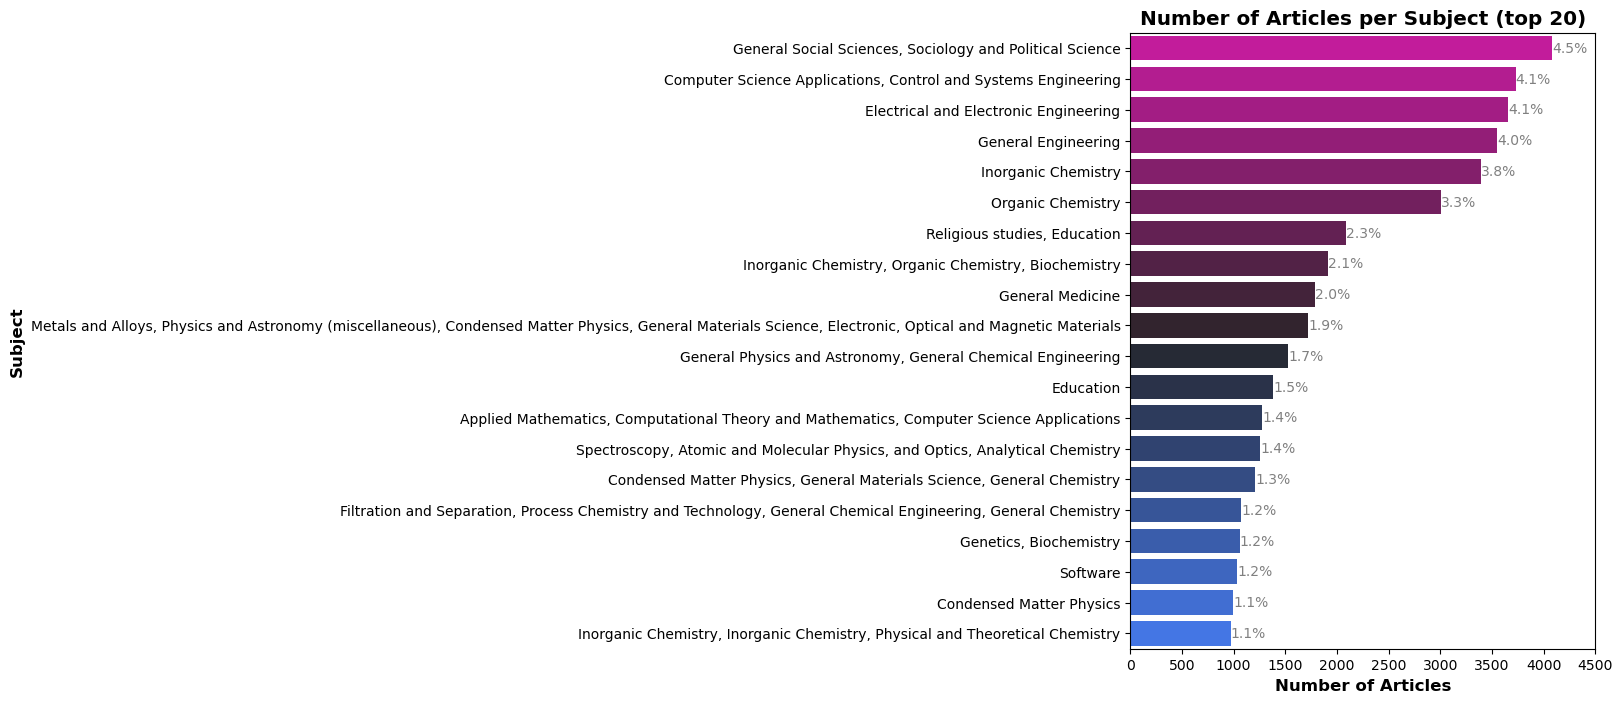

In [17]:
# Sort subject based on the number of articles
subjects_count = df2['subject'].value_counts().sort_values(ascending=False)
# Convert the Series to a DataFrame
subjects_count = subjects_count.reset_index()
subjects_count.columns = ['subject', 'article_count']

# Calculate the percentages and sort by descending order
subjects_percentage = (df2['subject'].value_counts(normalize=True) * 100).sort_values(ascending=False)
# Convert the Series to a DataFrame
subjects_percentage = subjects_percentage.reset_index()
subjects_percentage.columns = ['subject', 'article_percentage']

# Merge dataframes
subjects_df = pd.merge(subjects_count, subjects_percentage, on='subject')

# isolate top 20 subjects
top_subjects_df = subjects_df.head(20)
print('Top 20 subjects based on number of articles: ')
display(top_subjects_df)

# Create a custom color palette representing a gradient from blue to magenta
colors = sns.diverging_palette(330, 260, s=100, l=50, n=20, center="dark", as_cmap=False)

# Create the bar plot with the custom color palette
plt.figure(figsize=(6, 8))
barplot = sns.barplot(x='article_count', y='subject', data=top_subjects_df, palette=colors)

# Add percentages as text to the bar chart
for index, value in enumerate(top_subjects_df['article_count']):
    barplot.text(value, index, f'{top_subjects_df["article_percentage"].iloc[index]:.1f}%', ha='left', va='center', color='grey',)

plt.title('Number of Articles per Subject (top 20)', fontweight='bold', fontsize='x-large')
plt.xlabel('Number of Articles', fontweight='bold', fontsize='large')
plt.ylabel('Subject', fontweight='bold', fontsize='large')
plt.xlim(0,4500)

# Export figure
plt.savefig('barplot_subject_article_count_top_20.png', dpi=300, bbox_inches='tight')

# Display figure
plt.show()

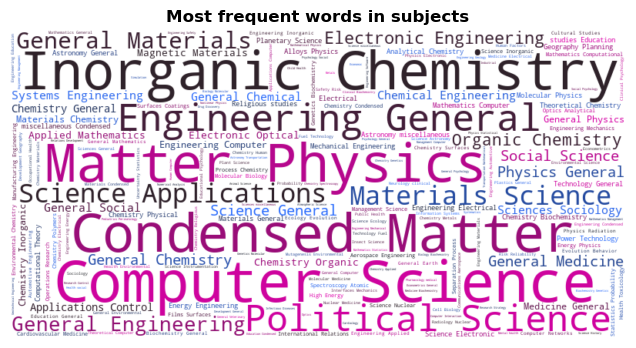

<Figure size 640x480 with 0 Axes>

In [19]:
# Convert the list of subjects into a single string, handling NaN values
text_subject = ' '.join(str(subject) for subject in df2['subject'] if pd.notnull(subject))

# Create a custom color palette representing a gradient from blue to magenta
colors = sns.diverging_palette(330, 260, s=100, l=50, n=2000, center="dark", as_cmap=False)

# Create a custom color function
def custom_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return tuple(int(x * 255) for x in colors[random_state.randint(0, len(colors) - 1)])  # Convert float to integer

# Plotting the wordcloud with custom colors
wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=custom_color_func).generate(text_subject)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in subjects', fontweight='bold', fontsize='large')

# Export figure
plt.savefig('wordcloud_subject_all.png', dpi=300, bbox_inches='tight')

# Display figure
plt.show()
plt.clf()

#### 3.1.2 Broader subject categories
I want condense the 2165 subjects into broader categories using text clustering or topic modeling to automatically group similar text strings into broad categories.  
These techniques can help summarize and categorize a large number of text strings without the need for manual effort.  

##### 3.1.2.1 K-means clustering
Let's start with text clustering using K-means clustering. K-means clustering is a popular unsupervised machine learning algorithm that groups similar data points into clusters.   
In the context of text data, we can use K-means clustering to group similar text strings (in this case, subjects) into broad categories.    
Here's a high-level overview of the steps involved in using K-means clustering for text data:  
- 1. **Text Preprocessing**: Preprocess the text data by tokenizing, removing stop words, and performing other text cleaning steps.
- 2. **Vectorization**: Convert the preprocessed text data into numerical vectors using techniques like TF-IDF (Term Frequency-Inverse Document Frequency) or word embeddings.
- 3. **K-means Clustering**: Apply K-means clustering to the vectorized text data to group similar text strings into clusters.  

In this example, we use TF-IDF vectorization to convert the text data into numerical vectors, and then apply K-means clustering to group the subjects into clusters. You can adjust the number of clusters based on your specific use case.


In [71]:
# Define custom stop words including 'english' and 'general'
custom_stop_words = ['english', 'general']

# Converting subject to strings and replacing missing values
text_data = df2['subject'].fillna('').astype(str)  # Convert to string type and replace missing values with empty string

# NOTE: every time you run this code, the proportions and cluster numbers will change
# Create a pipeline for K-means clustering with TF-IDF vectorization
pipeline = make_pipeline(
    TfidfVectorizer(stop_words=custom_stop_words, lowercase=True, analyzer='word'),  # Include custom stop words
    Normalizer(),
    KMeans(n_clusters=7, n_init=100)  # Explicitly set the value of n_init
)

# Fit the pipeline to the text data
pipeline.fit(text_data)

# Get the predicted cluster labels
cluster_labels = pipeline.predict(text_data)

# Add the cluster labels to the original dataframe
df2['subject_cluster_kmeans'] = cluster_labels
display(df2.head(2))


DOI           publisher                                          journal  references-count language                                            subject             type publication_date  publication_year            author author_lastname                                       better_title  title_length  subject_cluster_kmeans
0  10.1080/15326349508807347  Informa UK Limited  Communications in Statistics. Stochastic Models                22       en                            Modeling and Simulation  journal-article       1995-01-01            1995.0  Jorge Sá Esteves         Esteves  computing erlang–b function derivatives in the...          64.0                       4
1  10.1080/02642068700000008  Informa UK Limited                   The Service Industries Journal                11       en  Management of Technology and Innovation, Strat...  journal-article       1987-01-01            1987.0  David A. Collier         Collier         the customer service and quality challenge          42.0                       4

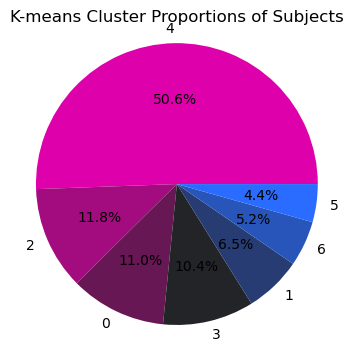

<Figure size 640x480 with 0 Axes>

In [73]:
# Create a custom color palette representing a gradient from blue to magenta
colors = sns.diverging_palette(330, 260, s=100, l=50, n=7, center="dark", as_cmap=False)

# Plotting a pie chart of the k-means subject_clusters
# Count the occurrences of each cluster
cluster_kmeans_counts = df2['subject_cluster_kmeans'].value_counts()

# Plot a pie chart
plt.figure(figsize=(4, 4))
plt.pie(cluster_kmeans_counts, labels=cluster_kmeans_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('K-means Cluster Proportions of Subjects')
plt.axis('equal')

# Export figure
plt.savefig('pie_subject_kmeans_clusters.png', dpi=300, bbox_inches='tight')

# Display figure
plt.show()
plt.clf()

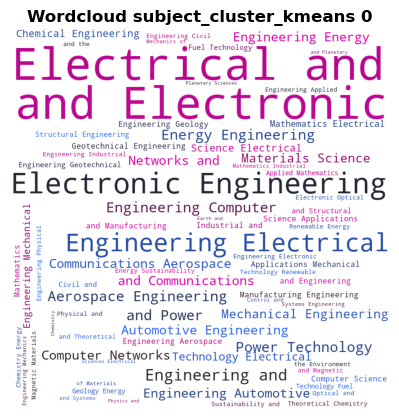

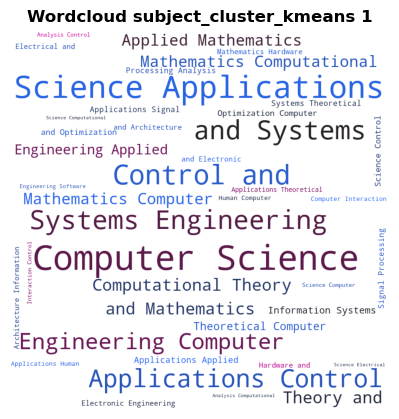

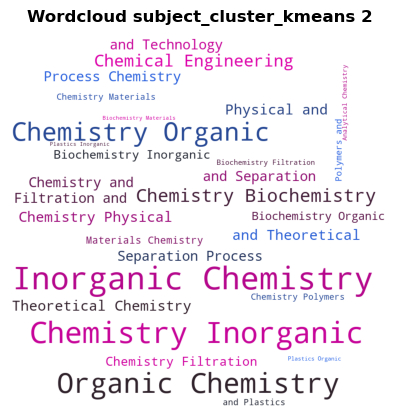

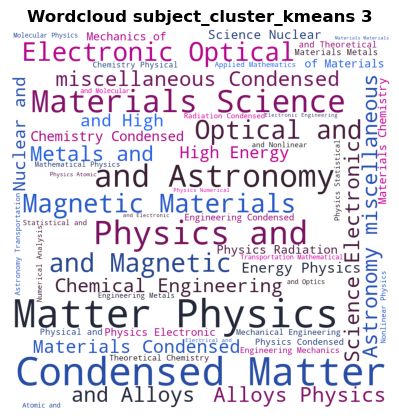

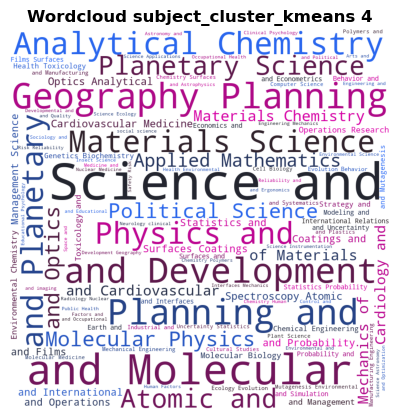

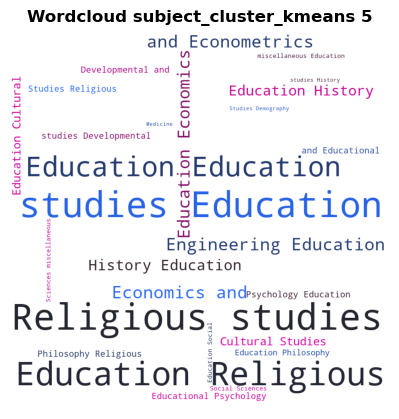

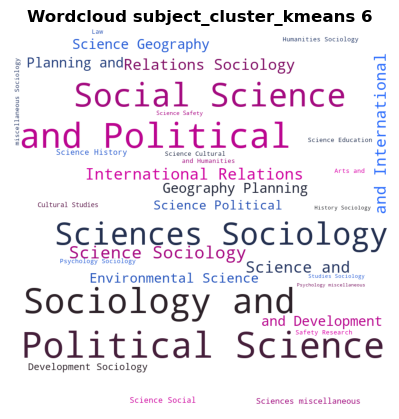

In [75]:
# Create a custom color palette representing a gradient from blue to magenta
colors = sns.diverging_palette(330, 260, s=100, l=50, n=200, center="dark", as_cmap=False)

# Create a custom color function
def custom_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return tuple(int(x * 255) for x in colors[random_state.randint(0, len(colors) - 1)])  # Convert float to integer

# Create a function to produce word clouds for each subject_cluster
def generate_wordclouds_for_subject_clusters(df, var):
    for cluster_number in range(7):  # Iterate through cluster numbers 0 to 7
        # Filter the dataframe for the specified cluster and convert 'subject' column to strings
        cluster_text = ' '.join(df[df[var] == cluster_number]['subject'].dropna().astype(str))

        # Check if cluster_text is not empty before generating the word cloud
        if cluster_text:
            # Generate the word cloud
            wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=custom_stop_words, min_font_size=10, color_func=custom_color_func).generate(cluster_text)

            # Display the word cloud
            plt.figure(figsize=(7, 4), facecolor=None)
            plt.imshow(wordcloud)
            plt.title(f'Wordcloud {var} {cluster_number}', fontweight='bold', fontsize='large')
            plt.axis("off")
            plt.tight_layout(pad=0)
            plt.savefig(f'wordcloud_{var}_{cluster_number}.png', dpi=300, bbox_inches='tight')
            plt.show()
        else:
            print(f"No words found for {var} {cluster_number}")

# Generate word clouds for K-means clustering
generate_wordclouds_for_subject_clusters(df2, 'subject_cluster_kmeans')


In [102]:
# Export data
df2.to_csv("scientific_papers_metadata_clean.csv", sep=',')

#### 3.1.13 Conclusions on Subjects
Among the 1265 subjects, the 10 most popular are:
- General Social Sciences, Sociology and Political Science                                                                                                     4082
- Computer Science Applications, Control and Systems Engineering                                                                                               3730
- Electrical and Electronic Engineering                                                                                                                        3654
- General Engineering                                                                                                                                          3551
- Inorganic Chemistry                                                                                                                                          3396
- Organic Chemistry                                                                                                                                            3003
- Religious studies, Education                                                                                                                                 2088
- Inorganic Chemistry, Organic Chemistry, Biochemistry                                                                                                         1913
- General Medicine                                                                                                                                             1789
- Metals and Alloys, Physics and Astronomy (miscellaneous), Condensed Matter Physics, General Materials Science, Electronic, Optical and Magnetic Materials    1724  

Defining broad categories using text k-means clustering method proved helpful as it created some clusters that were very specific (chemistry, or computer science).

### 3.2/ What are popular article types?
The 'type' column lists all the article categories.  
Let's find out in which article categories  are most published.

#### 3.2.1/ EDA

In [21]:
# what are the different article types?
print(df2.type.dtypes) # object, 
print('Number of article types: ', len(df2.type.unique())) # Number of article types:  9
display(df2.type.unique()) 
# ['journal-article','component','book-chapter','reference-entry','proceedings-article','monograph','report','other','book']

# Are there missing values in type?
print("Missing values in df.type:")
print(df2.type.isna().value_counts()) # 0 NAs and 103282 valid entries

object
Number of article types:  9


array(['journal-article', 'component', 'book-chapter', 'reference-entry',
       'proceedings-article', 'monograph', 'report', 'other', 'book'],
      dtype=object)

Missing values in df.type:
type
False    103282
Name: count, dtype: int64


type  article_count  article_percentage
0      journal-article          97103           94.017351
1  proceedings-article           3535            3.422668
2         book-chapter           2310            2.236595
3            component            125            0.121028
4               report            102            0.098759
5      reference-entry             54            0.052284
6                 book             22            0.021301
7            monograph             20            0.019364
8                other             11            0.010650

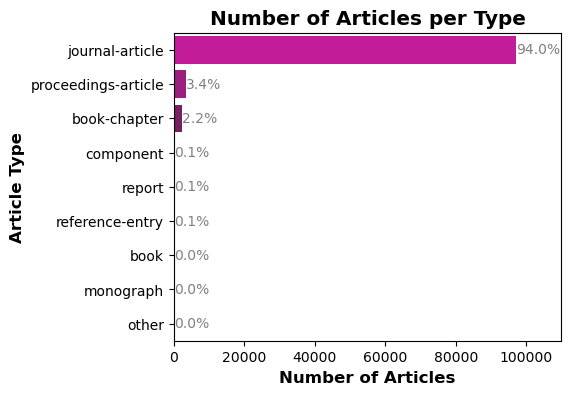

In [23]:
# Sort types based on the number of articles
types_count = df2['type'].value_counts().sort_values(ascending=False)
# Convert the Series to a DataFrame
types_count = types_count.reset_index()
types_count.columns = ['type', 'article_count']

# Calculate the percentages and sort by descending order
types_percentage = (df2['type'].value_counts(normalize=True) * 100).sort_values(ascending=False)
# Convert the Series to a DataFrame
types_percentage = types_percentage.reset_index()
types_percentage.columns = ['type', 'article_percentage']

# Merge dataframes
types_df = pd.merge(types_count, types_percentage, on='type')
display(types_df)

# Create a custom color palette representing a gradient from blue to magenta
colors = sns.diverging_palette(330, 260, s=100, l=50, n=9, center="dark", as_cmap=False)

# Create the bar plot with the custom color palette
plt.figure(figsize=(5, 4))
barplot = sns.barplot(x='article_count', y='type', data=types_df, palette=colors)

# Add percentages as text to the bar chart
for index, value in enumerate(types_df['article_count']):
    barplot.text(value, index, f'{types_df["article_percentage"].iloc[index]:.1f}%', ha='left', va='center', color='grey',)

plt.title('Number of Articles per Type', fontweight='bold', fontsize='x-large')
plt.xlabel('Number of Articles', fontweight='bold', fontsize='large')
plt.ylabel('Article Type', fontweight='bold', fontsize='large')
plt.xlim(-10,110000)

# Export figure
plt.savefig('barplot_type_article_count.png', dpi=300, bbox_inches='tight')

# Display figure
plt.show()


In [25]:
# checking data type of variable
print(df2.publication_year.dtypes) # int64

# how many years in this dataset
print(df2.publication_year.nunique()) # 113

# range of publication years
print('1st year: ', df2['publication_year'].min()) # 1st year: 1891
print('last year: ', df2['publication_year'].max()) # last year: 2014
print(df2.groupby(['publication_year','type']).size().min()) # 1
print(df2.groupby(['publication_year','type']).size().max()) # 18247

# Compute number of publications per year
article_per_year = df2['publication_year'].value_counts()

# Convert the Series to a DataFrame
article_per_year_df = article_per_year.reset_index()
article_per_year_df.columns = ['year', 'article_count']
display(article_per_year_df)

# Sort the top_subjects Series in descending order and print the top 10 subjects
#top_years_sorted = top_years.sort_values(ascending=False)
print("10 top years with the most publications: ")
print(article_per_year_df.head(10))
print("10 bottom years with the least publications: ")
print(article_per_year_df.tail(10))

# How many publications in 2014?
print("publications for 2014: ")
article_per_year_df.loc[article_per_year_df['year'] == 2014]['article_count'] # 1

Int64
113
1st year:  1891
last year:  2014
1
18247


year  article_count
0    2007          21153
1    2006           3372
2    1995           2570
3    1994           2477
4    2005           2463
..    ...            ...
108  1900             16
109  2010             12
110  1893              8
111  1894              5
112  2014              1

[113 rows x 2 columns]

10 top years with the most publications: 
   year  article_count
0  2007          21153
1  2006           3372
2  1995           2570
3  1994           2477
4  2005           2463
5  1996           2444
6  1993           2223
7  1997           2125
8  1998           2108
9  1999           2082
10 bottom years with the least publications: 
     year  article_count
103  1892             28
104  2009             22
105  1905             22
106  1907             20
107  1906             17
108  1900             16
109  2010             12
110  1893              8
111  1894              5
112  2014              1
publications for 2014: 


112    1
Name: article_count, dtype: Int64

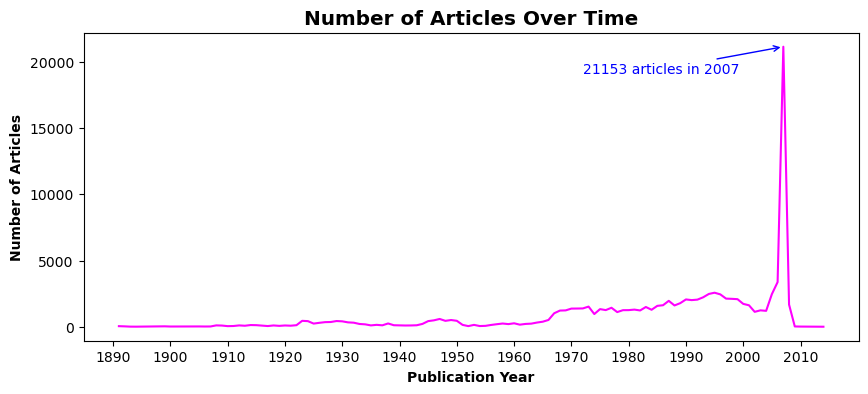

In [27]:
# Coerce the 'year' column to integer type for line plot
article_per_year_df['year'] = article_per_year_df['year'].astype(int)

# Create the line plot over time
plt.figure(figsize=(10, 4))
ax = sns.lineplot(data=article_per_year_df, x='year', y='article_count', color='magenta')
plt.title('Number of Articles Over Time', fontweight='bold', fontsize='x-large')
plt.xlabel('Publication Year', fontweight='bold', fontsize='medium')
plt.ylabel('Number of Articles', fontweight='bold', fontsize='medium')

# Set x-axis ticks to show every 10 years
plt.xticks(range(article_per_year_df['year'].min()-1, article_per_year_df['year'].max()+1, 10))

# Find the year with the maximum article_count
max_year = article_per_year_df.loc[article_per_year_df['article_count'].idxmax()]['year']
max_count = article_per_year_df['article_count'].max()

# Annotate the point with the maximum article_count to the left of the peak
ax.annotate(f'{max_count} articles in {max_year}', xy=(max_year, max_count), xytext=(max_year-35, max_count-2000), color='blue',
            arrowprops=dict(arrowstyle='->', color='blue'))

# Export figure
plt.savefig('lineplot_year_article_count.png', dpi=300, bbox_inches='tight')

# Display figure
plt.show()


#### 3.2.2/ Conclusion on article types
The most common type of documents published are journal articles (94%), followed by proceeding articles (3%) and book chapters (2%).   
The rate of publication is fairly constant from 1891 to 1960, after which it gradually increases to reach 2500 publications in the mid-90's.  
The is a huge spike of 18247 journal articles in 2007.


### 3.3/ What are the main publishers?
The 'publisher' column lists all the publishers.  
Let's find out which publishers are the most successful.

#### 3.3.1/ EDA
##### 3.3.1.1/ All journals considered

In [29]:
# what are the different publishers?
print(df2.publisher.dtypes) # object, 
print('Number of publishers: ', len(df2.publisher.unique())) # Number of publishers:  194

# Are there missing values in subject?
print("Missing values in df.publisher:")
print(df2.publisher.isna().value_counts()) # 0 NAs and 103282 valid entries

object
Number of publishers:  194
Missing values in df.publisher:
publisher
False    103282
Name: count, dtype: int64


Top 10 publishers based on number of articles: 


publisher  article_count  article_percentage
0                                 Informa UK Limited          49628           48.050967
1                                              Wiley          13324           12.900602
2  Institute of Electrical and Electronics Engine...           6861            6.642977
3                                        Elsevier BV           6442            6.237292
4                                  SAGE Publications           6211            6.013633
5            Springer Science and Business Media LLC           5255            5.088011
6                                               IEEE           2786            2.697469
7                         Springer Berlin Heidelberg           1293            1.251912
8                      Oxford University Press (OUP)            870            0.842354
9                                      Test accounts            750            0.726167

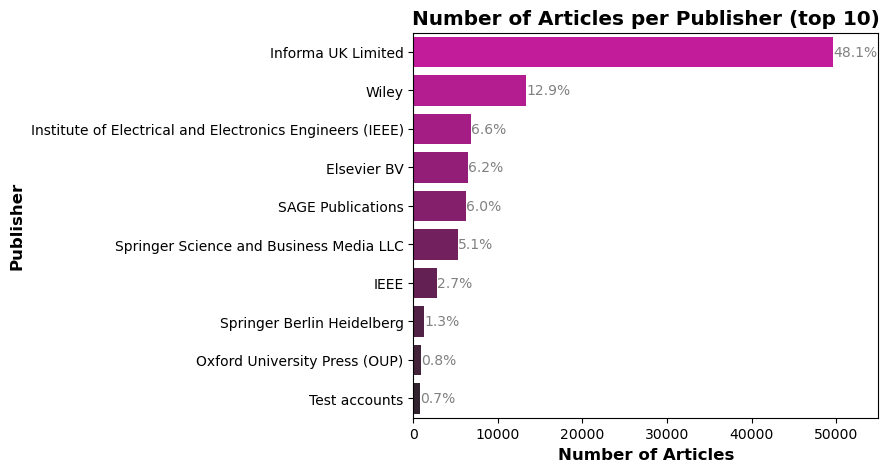

In [31]:
# Sort publisher based on the number of articles
publishers_count = df2['publisher'].value_counts().sort_values(ascending=False)
# Convert the Series to a DataFrame
publishers_count = publishers_count.reset_index()
publishers_count.columns = ['publisher', 'article_count']

# Calculate the percentages and sort by descending order
publishers_percentage = (df2['publisher'].value_counts(normalize=True) * 100).sort_values(ascending=False)
# Convert the Series to a DataFrame
publishers_percentage = publishers_percentage.reset_index()
publishers_percentage.columns = ['publisher', 'article_percentage']

# Merge dataframes
publishers_df = pd.merge(publishers_count, publishers_percentage, on='publisher')

# isolate top 10 publishers
top_publishers_df = publishers_df.head(10)
print('Top 10 publishers based on number of articles: ')
display(top_publishers_df)

# Create a custom color palette representing a gradient from blue to magenta
colors = sns.diverging_palette(330, 260, s=100, l=50, n=20, center="dark", as_cmap=False)

# Create the bar plot with the custom color palette
plt.figure(figsize=(6, 5))
barplot = sns.barplot(x='article_count', y='publisher', data=top_publishers_df, palette=colors)

# Add percentages as text to the bar chart
for index, value in enumerate(top_publishers_df['article_count']):
    barplot.text(value, index, f'{top_publishers_df["article_percentage"].iloc[index]:.1f}%', ha='left', va='center', color='grey',)

plt.title('Number of Articles per Publisher (top 10)', fontweight='bold', fontsize='x-large')
plt.xlabel('Number of Articles', fontweight='bold', fontsize='large')
plt.ylabel('Publisher', fontweight='bold', fontsize='large')
plt.xlim(0,55000)

# Export figure
plt.savefig('barplot_publisher_article_count_top_10.png', dpi=300, bbox_inches='tight')

# Display figure
plt.show()

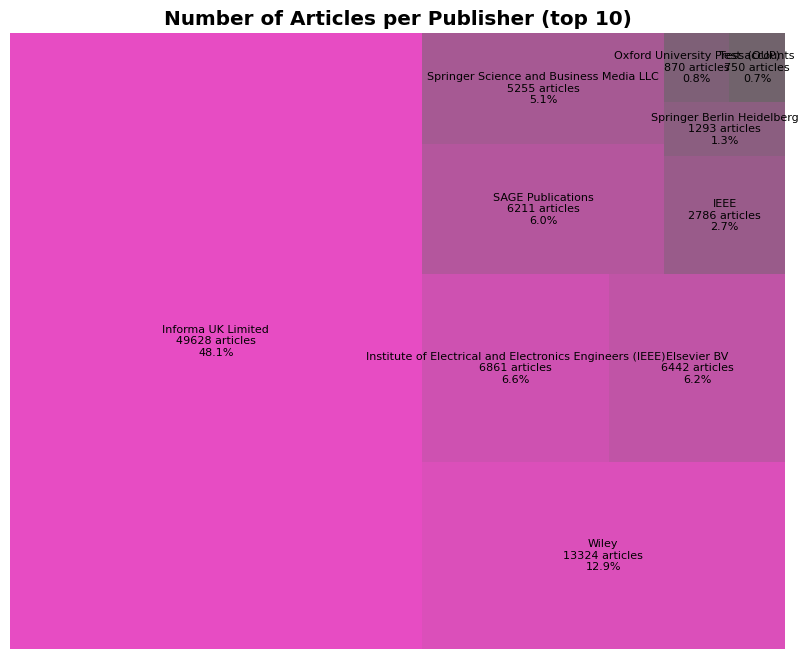

In [33]:
# Create a treemap of publishers
# Create a custom color palette representing a gradient from blue to magenta
colors = sns.diverging_palette(330, 260, s=100, l=50, n=20, center="dark", as_cmap=False)

# Create the treemap plot with the custom color palette
plt.figure(figsize=(10, 8))
squarify.plot(sizes=top_publishers_df['article_count'], label=top_publishers_df.apply(lambda x: f"{x['publisher']}\n{int(x['article_count'])} articles\n{round(x['article_percentage'], 1)}%", axis=1), color=colors, alpha=0.7, text_kwargs={'fontsize':8})
plt.axis('off')
plt.title('Number of Articles per Publisher (top 10)', fontweight='bold', fontsize='x-large')

# Display figure
plt.show()

##### 3.3.1.2/ How many journals per publisher

In [35]:
# Number of journals per publisher
journals_publishers = df2.groupby(['publisher'])['journal'].nunique().sort_values(ascending=False)

# Convert the Series to a DataFrame
journals_publishers = journals_publishers.reset_index()
journals_publishers.columns = ['publisher', 'journal_count']
print('Number of journals per publishers: ')
print(journals_publishers.head())

# Number of articles per journal and per publisher
journal_per_publisher = df2.groupby(['publisher','journal']).size().reset_index(name='article_count')
print('Number of publications per journal and publisher: ')
print(journal_per_publisher)
print('Top publishing journal and publisher: ', journal_per_publisher.max()) # 4082


Number of journals per publishers: 
                                 publisher  journal_count
0                              Elsevier BV            977
1  Springer Science and Business Media LLC            685
2                       Informa UK Limited            623
3                                    Wiley            372
4            Oxford University Press (OUP)            124
Number of publications per journal and publisher: 
                           publisher                                            journal  article_count
0                         ACTA Press  International Journal of Modelling and Simulation             13
1                     AIP Publishing                            Applied Physics Letters             64
2                     AIP Publishing  Chaos: An Interdisciplinary Journal of Nonline...             21
3                     AIP Publishing                         Journal of Applied Physics             45
4                     AIP Publishing              

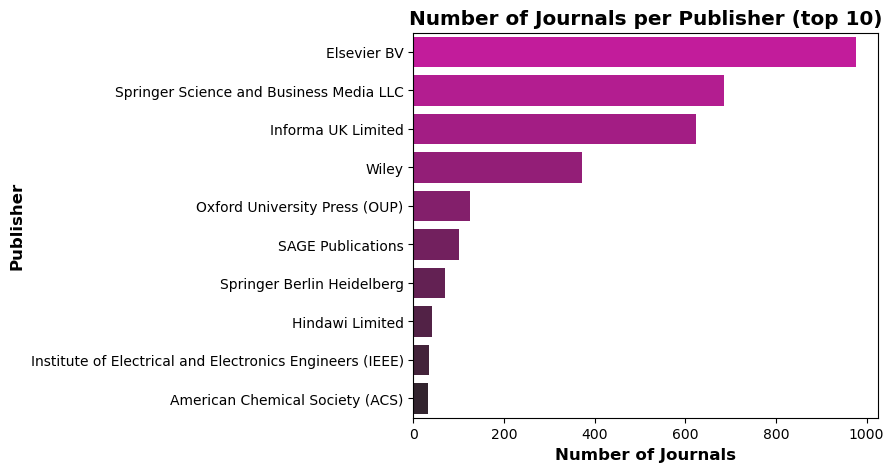

In [37]:
# isolate top 10 publishers with largest number of journals
top_journals_publishers = journals_publishers.head(10)

# Create a custom color palette representing a gradient from blue to magenta
colors = sns.diverging_palette(330, 260, s=100, l=50, n=20, center="dark", as_cmap=False)

# Create the bar plot
plt.figure(figsize=(6, 5))
sns.barplot(x='journal_count', y='publisher', data=top_journals_publishers, palette=colors)
plt.title('Number of Journals per Publisher (top 10)', fontweight='bold', fontsize='x-large')
plt.xlabel('Number of Journals', fontweight='bold', fontsize='large')
plt.ylabel('Publisher', fontweight='bold', fontsize='large')

# Export figure
plt.savefig('barplot_publisher_journal_count_top_10.png', dpi=300, bbox_inches='tight')

# Display figure
plt.show()


LM_articles_journals_publishers: 
(194, 3)


publisher  journal_count  article_count
0                                         ACTA Press              1             13
1                                     AIP Publishing              7            198
2                                     Allerton Press              5             56
3               American Academy of Pediatrics (AAP)              1              2
4    American Association for Cancer Research (AACR)              1              2
..                                               ...            ...            ...
189                           Walter de Gruyter GmbH             12            101
190                                White Horse Press              1              6
191                                            Wiley            372          13324
192                   World Scientific Pub Co Pte Lt             12             71
193                      Worldwide Protein Data Bank              0            125

[194 rows x 3 columns]

Intercept        10.462896
article_count     0.016355
dtype: float64
Pearson R results:  PearsonRResult(statistic=0.6191148221758016, pvalue=6.476005411750395e-22)


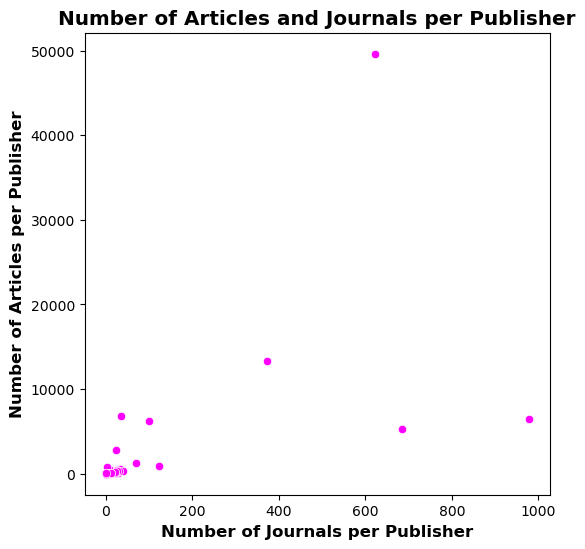

In [39]:
# is there a relationship between number articles/publisher and journals/publisher
# isolate variables for regression
LM_journals_per_publisher = df2.groupby(['publisher'])['journal'].nunique()
LM_articles_per_publisher = df2['publisher'].value_counts()
# Convert the Series to DataFrames
LM_journals_per_publisher = LM_journals_per_publisher.reset_index()
LM_journals_per_publisher.columns = ['publisher', 'journal_count']
LM_articles_per_publisher = LM_articles_per_publisher.reset_index()
LM_articles_per_publisher.columns = ['publisher', 'article_count']
# print('journals_per_publisher: ')
# print(LM_journals_per_publisher.shape) # (194,2)
# print(LM_journals_per_publisher)
# print('articles_per_publisher: ')
# print(LM_articles_per_publisher.shape) # (194,2)
# print(LM_articles_per_publisher)

# merge dataframes
LM_articles_journals_publishers = pd.merge(LM_journals_per_publisher, LM_articles_per_publisher, on='publisher')
print('LM_articles_journals_publishers: ')
print(LM_articles_journals_publishers.shape) # (194,3)
display(LM_articles_journals_publishers)

# Regression to compute publication rate
model_publisher = sm.OLS.from_formula('journal_count ~ article_count', data=LM_articles_journals_publishers)
result_publisher = model_publisher.fit()
print(result_publisher.params) 
print(result_publisher)
# Intercept        10.462896
# article_count     0.016355

# Extract coefficients for the linear model equation
intercept_result_publisher = result_publisher.params['Intercept']
slope_result_publisher = result_publisher.params['article_count']
LM_result_publisher = f'Model: journal_count = {slope_result_publisher:.3f} * article_count + {intercept_result_publisher:.1f}'

# Compute Pearson correlation coefficient
r_result_publisher = stats.pearsonr(LM_articles_journals_publishers['article_count'], LM_articles_journals_publishers['journal_count'])
print("Pearson R results: ", r_result_publisher) # Pearson R results:  PearsonRResult(statistic=0.6191148221758016, pvalue=6.476005411750395e-22)
R2_result_publisher = 'R2 = 0.62'

# Create a DataFrame for prediction with the required columns
prediction_data = pd.DataFrame({'article_count': LM_articles_journals_publishers['article_count'], 'journal_count': LM_articles_journals_publishers['journal_count']})

# Use the predict method with the new DataFrame
fitted_values = result_publisher.predict(prediction_data)

# scatterplot of articles/publisher and journals/publisher
plt.figure(figsize=(6, 6))
# Use the correct function to create the scatter plot
sns.scatterplot(x='journal_count', y='article_count', data=LM_articles_journals_publishers, color='magenta')

# # Adding the linear model 
# journal_counts = LM_articles_journals_publishers['journal_count'].unique()
# journal_counts.sort()
# plt.plot(journal_counts, fitted_values, color='black', linestyle='dashed', linewidth=2, label='Fitted Line')

# # Adding labels for top publishers 
# publisher_labels = list(LM_articles_journals_publishers['publisher'])
# for i, label in enumerate(publisher_labels):
#     if fitted_values[i] > 300:  # Adjust the condition based on your requirement
#         plt.text(LM_articles_journals_publishers['journal_count'][i], LM_articles_journals_publishers['article_count'][i], label, horizontalalignment='left', size='medium', color='black')

plt.title('Number of Articles and Journals per Publisher', fontweight='bold', fontsize='x-large')
plt.xlabel('Number of Journals per Publisher', fontweight='bold', fontsize='large')
plt.ylabel('Number of Articles per Publisher', fontweight='bold', fontsize='large')

# Export figure
plt.savefig('scatterplot_publisher_journal.png', dpi=300, bbox_inches='tight')

# Display figure
plt.show()

#### 3.3.2/ Conclusions
Publishers that publish the most are Informa UK Limited (49628 publications) and Wiley (13324 publications).  
Publishers that host the largest number of journals are Elsevier BV (977 journals), Springer Science and Business Media LLC (685 journals), Informa UK Limited (623 journals), and Wiley (372 journals).  
There is a strong positive relationship (R2=0.62) between number of publications and number of journals per publisher.

### 3.4/ Which journals publish the most?
The 'Journal' column lists all the journals.  
Let's find out which journals publish the largest number of documents.

#### 3.4.1/ EDA

In [41]:
# what are the different journals?
print(df2.journal.dtypes) # object, 
print('Number of journals: ', len(df2.journal.unique())) # Number of journals:  3717

# Are there missing values in subject?
print("Missing values in df.journal:")
print(df2.journal.isna().value_counts()) # 256 NAs and 103026 valid entries

object
Number of journals:  3717
Missing values in df.journal:
journal
False    103026
True        256
Name: count, dtype: int64


Top 10 journals based on number of articles: 


journal  article_count  article_percentage
0  The ANNALS of the American Academy of Politica...           4082            3.962107
1                   International Journal of Control           3689            3.580650
2                                 Chemische Berichte           3370            3.271019
3                             Proceedings of the IRE           3043            2.953623
4                           Synthetic Communications           2916            2.830354
5                                Religious Education           2078            2.016967
6  Phosphorus, Sulfur, and Silicon and the Relate...           1912            1.855842
7                             Philosophical Magazine           1807            1.753926
8                           Philosophical Magazine A           1724            1.673364
9                                  Radiation Effects           1628            1.580184

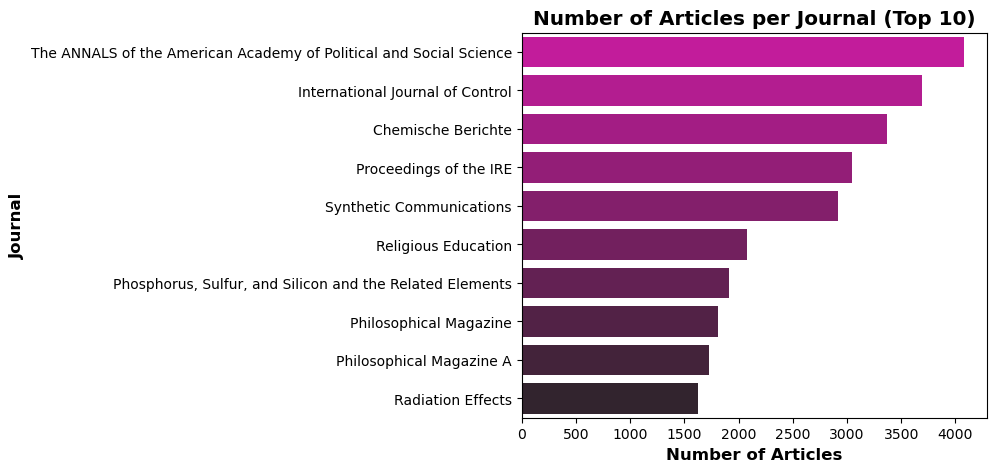

In [43]:
# Sort journals based on the number of articles
journals_count = df2['journal'].value_counts().sort_values(ascending=False)
# Convert the Series to a DataFrame
journals_count = journals_count.reset_index()
journals_count.columns = ['journal', 'article_count']

# Calculate the percentages and sort by descending order
journals_percentage = (df2['journal'].value_counts(normalize=True) * 100).sort_values(ascending=False)
# Convert the Series to a DataFrame
journals_percentage = journals_percentage.reset_index()
journals_percentage.columns = ['journal', 'article_percentage']

# Merge dataframes
journals_df = pd.merge(journals_count, journals_percentage, on='journal')

# isolate top 10 journals
top_journals_df = journals_df.head(10)
print('Top 10 journals based on number of articles: ')
display(top_journals_df)

# Create a custom color palette representing a gradient from blue to magenta
colors = sns.diverging_palette(330, 260, s=100, l=50, n=20, center="dark", as_cmap=False)

# Create the bar plot
plt.figure(figsize=(6, 5))
sns.barplot(x='article_count', y='journal', data=top_journals_df, palette=colors)
plt.title('Number of Articles per Journal (Top 10)', fontweight='bold', fontsize='x-large')
plt.xlabel('Number of Articles', fontweight='bold', fontsize='large')
plt.ylabel('Journal', fontweight='bold', fontsize='large')

# Export figure
plt.savefig('barplot_journal_article_count_top_10.png', dpi=300, bbox_inches='tight')

# Display figure
plt.show()


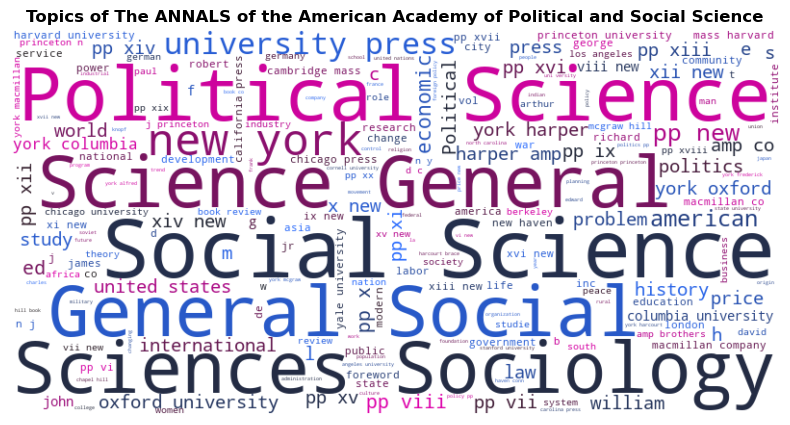

<Figure size 640x480 with 0 Axes>

In [59]:
# What are the prominent topics in the most successful journal?
top_journal = df2.loc[df2['journal'] == 'The ANNALS of the American Academy of Political and Social Science']

# Convert the list of subjects and titles into a single string, handling NaN values
top_journal_title = ' '.join(str(better_title) for better_title in top_journal['better_title'] if pd.notnull(better_title))
top_journal_subject = ' '.join(str(subject) for subject in top_journal['subject'] if pd.notnull(subject))
top_journal_text = top_journal_title + top_journal_subject

# Create a custom color palette representing a gradient from blue to magenta
colors = sns.diverging_palette(330, 260, s=100, l=50, n=200, center="dark", as_cmap=False)

# Create a custom color function
def custom_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return tuple(int(x * 255) for x in colors[random_state.randint(0, len(colors) - 1)])  # Convert float to integer

# Plotting the wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=custom_color_func).generate(top_journal_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Topics of The ANNALS of the American Academy of Political and Social Science', fontweight='bold', fontsize='large')

# Export figure
plt.savefig('wordcloud_top1_journal.png', dpi=300, bbox_inches='tight')

# Display figure
plt.show()
plt.clf()


#### 3.4.2/ Conclusions
The most publishing journals are The ANNALS of the American Academy of Politica (4082 publications), International Journal of Control (3689 publications), Chemische Berichte (3370 publications), and Proceedings of the IRE (3043 publications).  
The top journal deals with sociology, social and political sciences.

### 3.5/ How do the number of rerefences trend?
The 'references_count' column lists the number of references per article.  
Let's find out if that number has evolved over time and if there is a link with the document type.

#### 3.5.1/ EDA

Quartiles of references_count: 


count    103282.000000
mean         15.780417
std          22.537253
min           0.000000
25%           0.000000
50%          11.000000
75%          22.000000
max        1452.000000
Name: references-count, dtype: float64

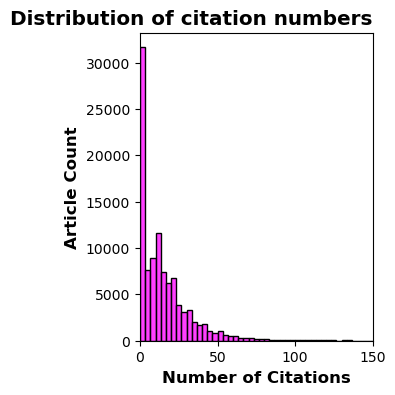

In [45]:
# Compute quartiles
print('Quartiles of references_count: ')
display(df2['references-count'].describe())

# create a histogram
plt.figure(figsize=(3,4))
sns.histplot(data=df2, x=df2['references-count'], bins=150, binrange=(0,500), color='magenta', edgecolor='black', linewidth=1)
plt.title('Distribution of citation numbers', fontweight='bold', fontsize='x-large', loc='right')
plt.xlabel('Number of Citations', fontweight='bold', fontsize='large')
plt.ylabel('Article Count', fontweight='bold', fontsize='large')
plt.xlim(0,150)
# Export figure
plt.savefig('histogram_reference_count.png', dpi=300, bbox_inches='tight')

# Display figure
plt.show()

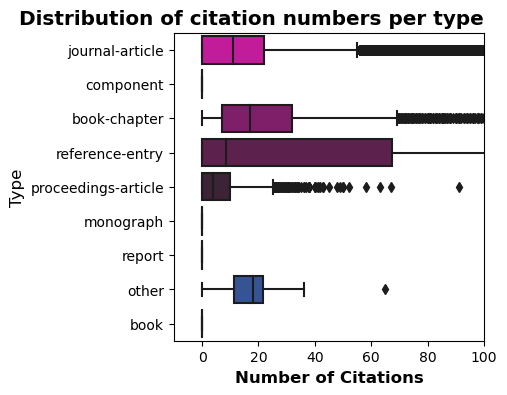

In [47]:
# Create a custom color palette representing a gradient from blue to magenta
colors = sns.diverging_palette(330, 260, s=100, l=50, n=10, center="dark", as_cmap=False)

# create a boxlot
plt.figure(figsize=(4,4))
sns.boxplot(data=df2, x=df2['references-count'], y=df2['type'], palette=colors)
plt.title('Distribution of citation numbers per type', fontweight='bold', fontsize='x-large', loc='right')
plt.xlabel('Number of Citations', fontweight='bold', fontsize='large')
plt.ylabel('Type', fontsize='large')
plt.xlim(-10,100)
# Export figure
plt.savefig('boxplot_reference_type.png', dpi=300, bbox_inches='tight')

# Display figure
plt.show()

median_ref_per_year: 
(113, 2)


publication_year  median_references_count
0                1891                      0.0
1                1892                      0.0
2                1893                      0.0
3                1894                      0.0
4                1899                      0.0
..                ...                      ...
108              2007                     18.0
109              2008                     25.0
110              2009                     32.0
111              2010                     12.5
112              2014                      0.0

[113 rows x 2 columns]

converted median_ref_per_year.publication_year types:  int32


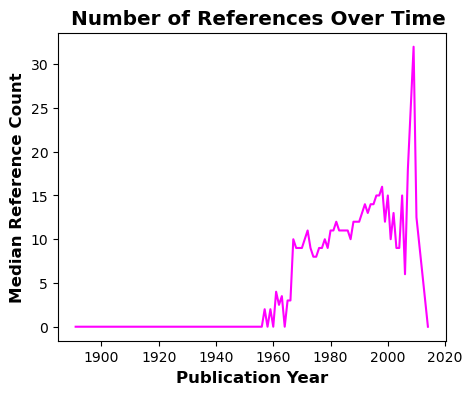

In [51]:
# NOTE: due to outliers, use median instead of mean
# isolate variables for lineplot
median_ref_per_year = df2.groupby(['publication_year'])['references-count'].median()
# Convert the Series to DataFrames
median_ref_per_year = median_ref_per_year.reset_index()
median_ref_per_year.columns = ['publication_year', 'median_references_count']
print('median_ref_per_year: ')
print(median_ref_per_year.shape) # (113, 2)
display(median_ref_per_year)

# convert year to int for lineplot
median_ref_per_year.publication_year = median_ref_per_year.publication_year.astype(int)
print('converted median_ref_per_year.publication_year types: ', median_ref_per_year.publication_year.dtypes) # int32

# create a lineplot over time
plt.figure(figsize=(5, 4))
sns.lineplot(data=median_ref_per_year, x='publication_year', y='median_references_count', color='magenta')
plt.title('Number of References Over Time', fontweight='bold', fontsize='x-large', loc='right')
plt.xlabel('Publication Year', fontweight='bold', fontsize='large')
plt.ylabel('Median Reference Count', fontweight='bold', fontsize='large')

# Export figure
plt.savefig('lineplot_reference_year.png', dpi=300, bbox_inches='tight')

# Display figure
plt.show()

#### 3.5.2/ Conclusions
The distribution is highly right-skewed, meaning that most article have 0-20 references, with a few outliers featuring > 200 citations.  
The average number of references per article was almost non existent from 1891-1955, bar 2 spikes in 1913-1916 (33 citations in 1914) and 1934 (5 citations).  
It steadily increased from 1956 to 2010 with a peak at 35 in 2009.  


### 3.6/ What is the main language used by authors?
The 'language' column lists the languages abbreviated.  
Let's find out if what are the main laguages and which one is favored.
Is it linked to a subject?

#### 3.6.1/ EDA

In [53]:
# what are the different languages?
print(df2.language.dtypes) # object, 
print('Number of languages: ', len(df2.language.unique())) # Number of publishers:  6
print(df2.language.unique()) # ['en' 'de' nan 'ja' 'fr' 'it']

# Are there missing values in language?
print("Missing values in df.language:")
print(df2.language.isna().value_counts()) # 14735 NAs and 88907 valid entries

object
Number of languages:  6
['en' 'de' nan 'ja' 'fr' 'it']
Missing values in df.language:
language
False    88907
True     14375
Name: count, dtype: int64


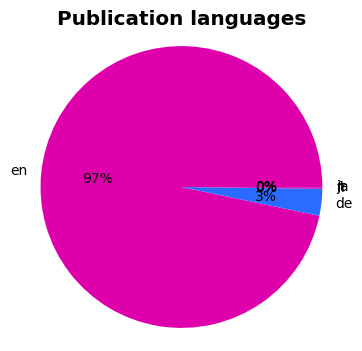

<Figure size 640x480 with 0 Axes>

In [55]:
# Create a custom color palette representing a gradient from blue to magenta
colors = sns.diverging_palette(330, 260, s=100, l=50, n=2, center="dark", as_cmap=False)

# Plotting a pie chart of the languages
# Count each languages
language_counts = df2['language'].value_counts()

# Plot a pie chart
plt.figure(figsize=(4, 4))
plt.pie(language_counts, labels=language_counts.index, autopct='%1.0f%%', colors=colors)
plt.title('Publication languages', fontweight='bold', fontsize='x-large', loc='center')
plt.axis('equal')
# Export figure
plt.savefig('piechart_language.png', dpi=300, bbox_inches='tight')
# Display figure
plt.show()
plt.clf()

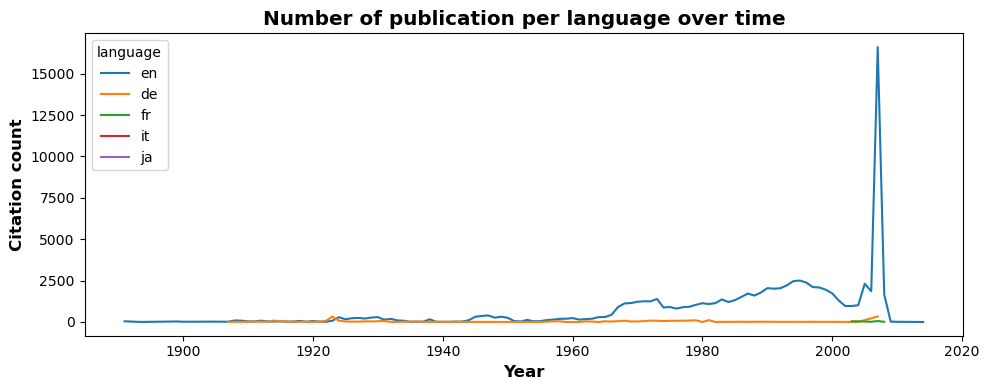

In [57]:
# Convert 'publication_year' column to integer type
df2['publication_year'] = df2['publication_year'].dropna().astype(int)

#language_labels = df2['language'].unique()

# Aggregate the data by 'publication_year' and 'language'
agg_data = df2.groupby(['publication_year', 'language'])['DOI'].count().reset_index()


# Create line plot
plt.figure(figsize=(10, 4))
plot = sns.lineplot(data=agg_data, x='publication_year', y='DOI', hue='language')
plt.title('Number of publication per language over time', fontweight='bold', fontsize='x-large')
plt.xlabel('Year', fontweight='bold', fontsize='large')
plt.ylabel('Citation count', fontweight='bold', fontsize='large')

plt.tight_layout()
plt.savefig('lineplot_language_time.png', dpi=300, bbox_inches='tight')
# Display figure
plt.show()


#### 3.6.2/ Conclusions
English is overwhelmingly (97%) the language used for publication purpose, followed by Deutch (3%).

### 3.7/ Who are the most prolific authors authors
The column 'first_author' in df2 lists all the authors' last names.  However, as last common names will be shared across different authors, we must used the "author" column from df1.
Let's analyse it to find which authors publish the most. 
#### 3.7.1/ EDA

In [59]:
# how many unique authors are there?
print(df2.author.dtypes) # object, 
print('Number of authors: ', len(df2.author.unique())) # Number of first authors:  81743

# Are there missing values in subject?
print("Missing values in df.first_author:")
print(df2.author.isna().value_counts()) # 0 NAs and 103282 valid entries

object
Number of authors:  81743
Missing values in df.first_author:
author
False    103282
Name: count, dtype: int64


author
Ferdinand Bohlmann    124
D.A. Michalopoulos     68
John Bauer             60
D. J. Evans            54
L.W. Austin            53
                     ... 
V. S. Ramamurthy        1
Marc. Baer              1
Peter J. Rimmer         1
Masaki Kohda            1
K. H. Jost              1
Name: count, Length: 81743, dtype: int64
Top 10 authors: 
               author  article_count
0  Ferdinand Bohlmann            124
1  D.A. Michalopoulos             68
2          John Bauer             60
3         D. J. Evans             54
4         L.W. Austin             53
5    C. Richard Conti             53
6        Hans Paulsen             50
7      Russell Forbes             47
8      T.R. Gilliland             45
9   Hubert Schmidbaur             44


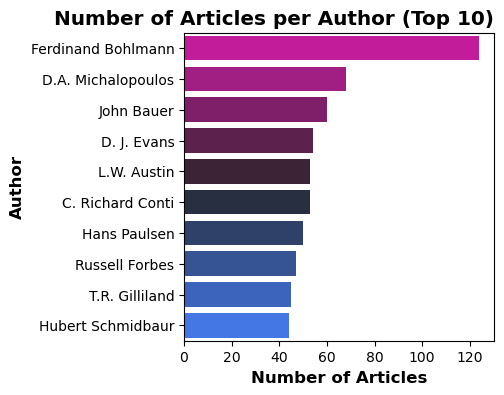

In [61]:
# Sort authors based on the number of articles
authors_sorted = df2.author.value_counts().sort_values(ascending=False)
print(authors_sorted)

# Convert the Series to a DataFrame
authors_sorted = authors_sorted.reset_index()
authors_sorted.columns = ['author', 'article_count']

# isolate most prolific authors
top_authors_sorted = authors_sorted.head(10)
print('Top 10 authors: ')
print(top_authors_sorted)

# Create a custom color palette representing a gradient from blue to magenta
colors = sns.diverging_palette(330, 260, s=100, l=50, n=10, center="dark", as_cmap=False)

# Create the bar plot
plt.figure(figsize=(4, 4))
sns.barplot(x='article_count', y='author', data=top_authors_sorted, palette=colors)
plt.title('Number of Articles per Author (Top 10)', fontweight='bold', fontsize='x-large', loc='right')
plt.xlabel('Number of Articles', fontweight='bold', fontsize='large')
plt.ylabel('Author', fontweight='bold', fontsize='large')
# Export figure
plt.savefig('barplot_author.png', dpi=300, bbox_inches='tight')
# Display figure
plt.show()


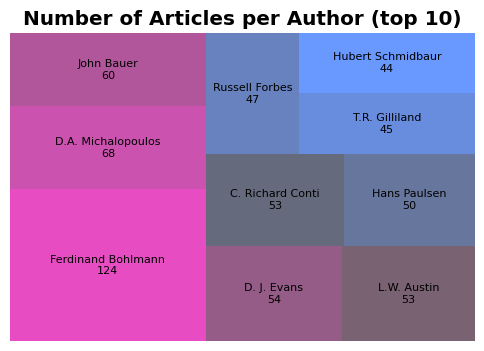

In [63]:
# Create a treemap of top authors
# Create a custom color palette representing a gradient from blue to magenta
colors = sns.diverging_palette(330, 260, s=100, l=50, n=10, center="dark", as_cmap=False)

# Create the treemap plot with the custom color palette
plt.figure(figsize=(6, 4))
squarify.plot(sizes=top_authors_sorted['article_count'], label=top_authors_sorted.apply(lambda x: f"{x['author']}\n{int(x['article_count'])}", axis=1), color=colors, alpha=0.7, text_kwargs={'fontsize':8})
plt.axis('off')
plt.title('Number of Articles per Author (top 10)', fontweight='bold', fontsize='x-large')
# Export figure
plt.savefig('treemap_author.png', dpi=300, bbox_inches='tight')
# Display figure
plt.show()

In [79]:
def get_top_authors_publications(df, n):
    # Sort authors based on the number of articles
    authors_sorted = df['author'].value_counts().sort_values(ascending=False)
    
    # Convert the Series to a DataFrame
    authors_sorted = authors_sorted.reset_index()
    authors_sorted.columns = ['author', 'article_count']
    
    # Select the top N most prolific authors
    top_authors = authors_sorted.head(n)['author'].tolist()
    
    # Create a dictionary to store the publications by the top authors
    top_authors_publications = {}
    
    # Iterate through the top authors and store their publications in the dictionary
    for author in top_authors:
        top_authors_publications[author] = df[df['author'] == author]
    
    return top_authors_publications

top_authors_publications = get_top_authors_publications(df2, 4)

# Print the list of publications by each top author
for author, publications in top_authors_publications.items():
    print(f'List of publications by {author}:')
    display(publications.head(2))

List of publications by Ferdinand Bohlmann:


DOI publisher             journal  references-count language              subject             type publication_date  publication_year              author author_lastname                                       better_title  title_length  subject_cluster_kmeans
15863  10.1002/cber.19671000419     Wiley  Chemische Berichte                 5       en  Inorganic Chemistry  journal-article       1967-04-01            1967.0  Ferdinand Bohlmann        Bohlmann  polyacetylenverbindungen, cxxv. über die inhal...         112.0                       5
15936  10.1002/cber.19671001038     Wiley  Chemische Berichte                 9       en  Inorganic Chemistry  journal-article       1967-10-01            1967.0  Ferdinand Bohlmann        Bohlmann  polyacetylenverbindungen, cxxxix. notiz über d...          99.0                       5

List of publications by D.A. Michalopoulos:


DOI                                          publisher   journal  references-count language                   subject             type publication_date  publication_year              author author_lastname      better_title  title_length  subject_cluster_kmeans
15143  10.1109/c-m.1977.217505  Institute of Electrical and Electronics Engine...  Computer                 0      NaN  General Computer Science  journal-article       1977-01-01            1977.0  D.A. Michalopoulos   Michalopoulos  new applications          16.0                       0
15242  10.1109/c-m.1975.219004  Institute of Electrical and Electronics Engine...  Computer                 0      NaN  General Computer Science  journal-article       1975-06-01            1975.0  D.A. Michalopoulos   Michalopoulos      new products          12.0                       0

List of publications by John Bauer:


DOI publisher                    journal  references-count language subject             type publication_date  publication_year      author author_lastname                                       better_title  title_length  subject_cluster_kmeans
16412  10.1002/ncr.4110141208     Wiley  National Municipal Review                 0       en     NaN  journal-article       1925-12-01            1925.0  John Bauer           Bauer  chief elements of controversy in public utilit...         106.0                       4
27921  10.1002/ncr.4110131003     Wiley  National Municipal Review                 0       en     NaN  journal-article       1924-10-01            1924.0  John Bauer           Bauer  ne york's transit control is reorganized. the ...         104.0                       4

List of publications by D. J. Evans:


DOI           publisher                                        journal  references-count language                                            subject             type publication_date  publication_year       author author_lastname                                       better_title  title_length  subject_cluster_kmeans
1699  10.1080/00207169108803981  Informa UK Limited  International Journal of Computer Mathematics                 6       en  Applied Mathematics, Computational Theory and ...  journal-article       1991-01-01            1991.0  D. J. Evans           Evans  the solution of poisson's equation in a triang...          57.0                       4
1997  10.1080/00207160008804920  Informa UK Limited  International Journal of Computer Mathematics                 6       en  Applied Mathematics, Computational Theory and ...  journal-article       2000-01-01            2000.0  D. J. Evans           Evans  a systolic processor array for the quadrant in...          75.0                       4

In [81]:
# creating a shape mask for the wordcloud -- NOTE: make sure the background is transparent!
person_mask = np.array(Image.open("icon_person.png"))
print(person_mask)
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

# Transform  mask into a new one that will work with the function:
transformed_person_mask = np.ndarray((person_mask.shape[0],person_mask.shape[1]), np.int32)

for i in range(len(person_mask)):
    transformed_person_mask[i] = list(map(transform_format, person_mask[i]))    

# Check the expected result of your mask
print(transformed_person_mask)

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [252 252 252 ... 252 252 252]
 [252 252 252 ... 252 252 252]
 [252 252 252 ... 252 252 252]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [252 252 252 ... 252 252 252]
 [252 252 252 ... 252 252 252]
 [252 252 252 ... 252 252 252]]


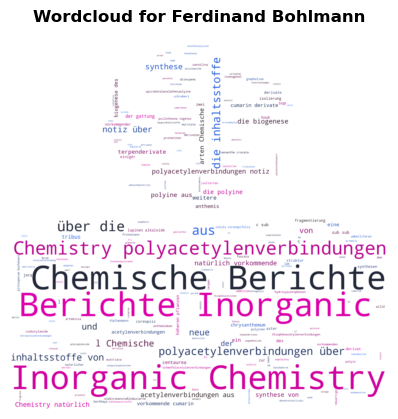

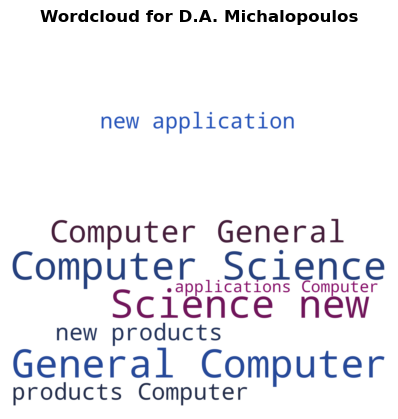

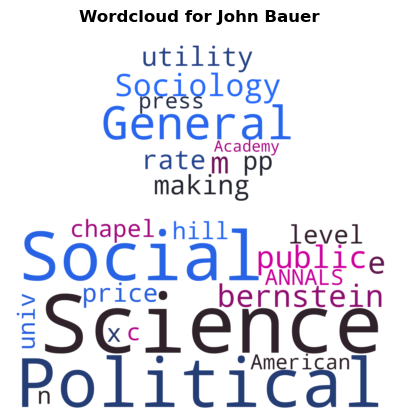

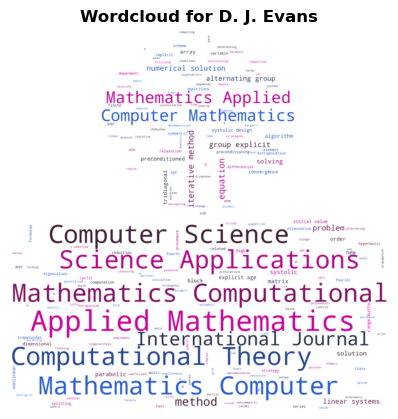

In [85]:
# Create a custom color palette representing a gradient from blue to magenta
colors = sns.diverging_palette(330, 260, s=100, l=50, n=50, center="dark", as_cmap=False)

# Create a custom color function
def custom_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return tuple(int(x * 255) for x in colors[random_state.randint(0, len(colors) - 1)])  # Convert float to integer

# Create a function to produce word clouds for each top author
def generate_wordclouds_for_top_authors(top_authors_publications):
    for author, publications in top_authors_publications.items():
        # Concatenate the text from 'subject', 'better_title', and 'journal' columns for each author
        author_text = ' '.join(publications[['subject', 'better_title', 'journal']].dropna().astype(str).values.flatten())

        # Check if author_text is not empty before generating the word cloud
        if author_text:
            # Generate the word cloud
            wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10, mask=transformed_person_mask, color_func=custom_color_func).generate(author_text)

            # Display the word cloud
            plt.figure(figsize=(7, 4), facecolor=None)
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.title(f'Wordcloud for {author}', fontweight='bold', fontsize='large')
            plt.axis("off")
            plt.tight_layout(pad=0)
            plt.savefig(f'Wordcloud_for_{author}.png')
            plt.show()
        else:
            print(f"No words found for {author}")

# Generate word clouds for the top authors
generate_wordclouds_for_top_authors(top_authors_publications)

In [89]:
# what are the most common last names?
# to find out we can use column 'author_lastname' from df2
last_names_sorted = df2.author_lastname.value_counts().sort_values(ascending=False)
print(last_names_sorted)

author_lastname
Wang          488
Zhang         394
Lee           394
Li            379
Chen          378
             ... 
Hayashimto      1
Bisht           1
Palanivelu      1
Fraker          1
Conboy          1
Name: count, Length: 46003, dtype: int64


#### 3.7.2/ 
The most prolific authors are Ferdinand Bohlmann a chemist interested in inorganic chemistry with 124 publications, followed by D.A. Michalopoulos interested in Computer Science with 68 publications, and John Bauer a municipal public servant with 60 publications.  
The most common last names are short and of Asian origin (Wang, Zhang, Lee, Li, Chen).

### 3.8/ Title
The column 'better_title' in df2 lists all the publications' titles.
Let's analyse its length from column 'title_length'.
Let's analyse it to find how some keywords tracked over time. 
#### 3.8.1/ EDA

Quartiles of title_length: 


count    103256.000000
mean         80.810800
std          43.506315
min           1.000000
25%          53.000000
50%          75.000000
75%         101.000000
max        2421.000000
Name: title_length, dtype: float64

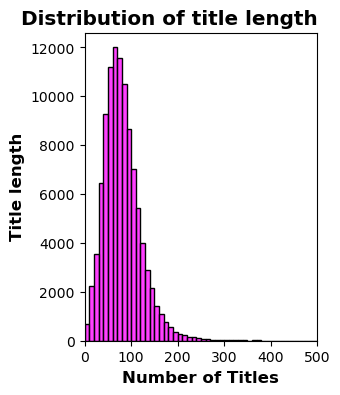

In [65]:
# Compute quartiles
print('Quartiles of title_length: ')
display(df2['title_length'].describe())

# create a histogram
plt.figure(figsize=(3,4))
sns.histplot(data=df2, x=df2['title_length'], bins=50, binrange=(0,500), color='magenta', edgecolor='black', linewidth=1)
plt.title('Distribution of title length', fontweight='bold', fontsize='x-large', loc='right')
plt.xlabel('Number of Titles', fontweight='bold', fontsize='large')
plt.ylabel('Title length', fontweight='bold', fontsize='large')
plt.xlim(0,500)
# Export figure
plt.savefig('histogram_title_length.png', dpi=300, bbox_inches='tight')

# Display figure
plt.show()

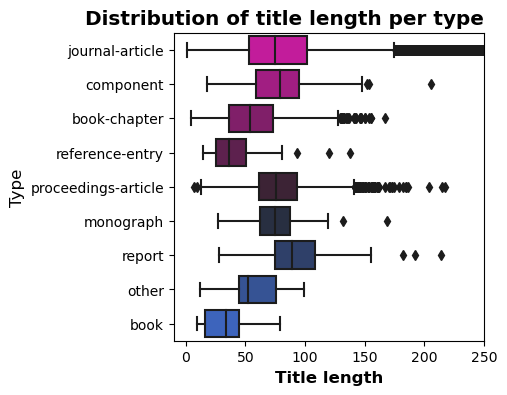

In [67]:
# Create a custom color palette representing a gradient from blue to magenta
colors = sns.diverging_palette(330, 260, s=100, l=50, n=10, center="dark", as_cmap=False)

# create a boxlot
plt.figure(figsize=(4,4))
sns.boxplot(data=df2, x=df2['title_length'], y=df2['type'], palette=colors)
plt.title('Distribution of title length per type', fontweight='bold', fontsize='x-large', loc='right')
plt.xlabel('Title length', fontweight='bold', fontsize='large')
plt.ylabel('Type', fontsize='large')
plt.xlim(-10,250)
# Export figure
plt.savefig('boxplot_title-length_type.png', dpi=300, bbox_inches='tight')
# Display figure
plt.show()

median_title_per_year: 
(113, 2)


publication_year  median_title_length
0              1891.0                129.0
1              1892.0                 59.5
2              1893.0                 45.0
3              1894.0                 39.0
4              1899.0                148.0
..                ...                  ...
108            2007.0                 84.0
109            2008.0                 90.0
110            2009.0                 87.5
111            2010.0                 66.5
112            2014.0                105.0

[113 rows x 2 columns]

converted median_title_per_year.publication_year types:  int32


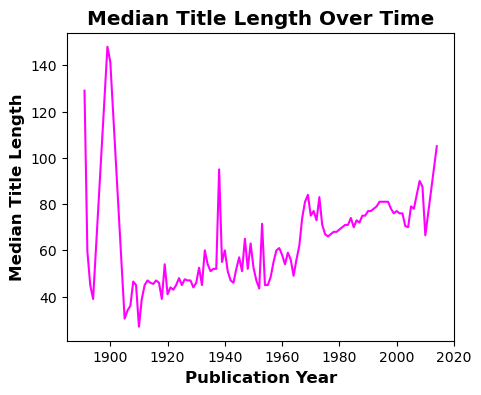

In [69]:
# as tere are outliers, use median instead of mean
# isolate variables for lineplot
median_title_per_year = df2.groupby(['publication_year'])['title_length'].median()
# Convert the Series to DataFrames
median_title_per_year = median_title_per_year.reset_index()
median_title_per_year.columns = ['publication_year', 'median_title_length']
print('median_title_per_year: ')
print(median_title_per_year.shape) # (113, 2)
display(median_title_per_year)

# convert year to int for lineplot
median_title_per_year.publication_year = median_title_per_year.publication_year.astype(int)
print('converted median_title_per_year.publication_year types: ', median_title_per_year.publication_year.dtypes) # int32

# create a lineplot over time
plt.figure(figsize=(5, 4))
sns.lineplot(data=median_title_per_year, x='publication_year', y='median_title_length', color='magenta')  # corrected variable name
plt.title('Median Title Length Over Time', fontweight='bold', fontsize='x-large', loc='center')
plt.xlabel('Publication Year', fontweight='bold', fontsize='large')
plt.ylabel('Median Title Length', fontweight='bold', fontsize='large')

# Export figure
plt.savefig('lineplot_title-length_year.png', dpi=300, bbox_inches='tight')

# Display figure
plt.show()

### 3.9/ Subject cluster and Research topics
Let's select one of the subject kmeans clusters  (3 = physics, 10.3% of data or 2 = chemistry, 11% data) and explore the titles to see which topics are of interest amd how they evolved over time.  
#### 3.9.1/ EDA using k-means cluster 2 = chemistry, 11% data

In [134]:
# filter the data to select cluster 2 (chemistry) and define 3 periods
def split_df_by_year_and_cluster(df, cluster_number):
    # Filter the data to select the specified cluster
    kmeans_i = df[df['subject_cluster_kmeans'] == cluster_number]

    # Create the 1st dataframe for years 1950-1980
    df_1950_1980 = kmeans_i[(kmeans_i['publication_year'] >= 1950) & (kmeans_i['publication_year'] <= 1980)]
    print("Dimensions of kmeans_{}_1950_1980 dataframe:".format(cluster_number), df_1950_1980.shape)

    # Create the 2nd dataframe for years 1981-2000
    df_1981_2000 = kmeans_i[(kmeans_i['publication_year'] >= 1981) & (kmeans_i['publication_year'] <= 2000)]
    print("Dimensions of kmeans_{}_1981_2000 dataframe:".format(cluster_number), df_1981_2000.shape)

    # Create the 3rd dataframe for years 2001-2014
    df_2001_2014 = kmeans_i[(kmeans_i['publication_year'] >= 2001) & (kmeans_i['publication_year'] <= 2014)]
    print("Dimensions of kmeans_{}_2001_2014 dataframe:".format(cluster_number), df_2001_2014.shape)

    return df_1950_1980, df_1981_2000, df_2001_2014

# Run function for cluster 2
kmeans_2_1950_1980, kmeans_2_1981_2000, kmeans_2_2001_2014 = split_df_by_year_and_cluster(df2, 2)


Dimensions of kmeans_2_1950_1980 dataframe: (4070, 14)
Dimensions of kmeans_2_1981_2000 dataframe: (6943, 14)
Dimensions of kmeans_2_2001_2014 dataframe: (1220, 14)


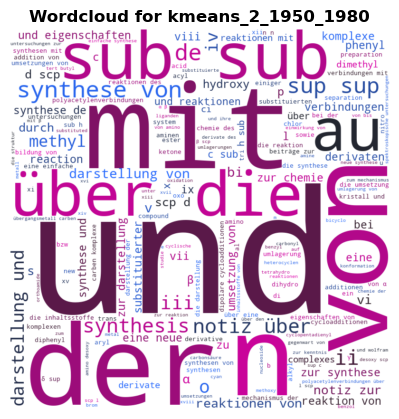

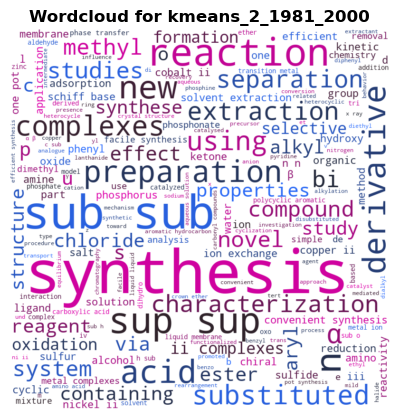

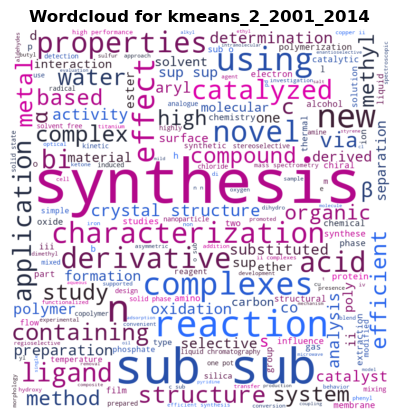

In [136]:
# Create a custom color palette representing a gradient from blue to magenta
colors = sns.diverging_palette(330, 260, s=100, l=50, n=50, center="dark", as_cmap=False)

# Create a custom color function
def custom_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return tuple(int(x * 255) for x in colors[random_state.randint(0, len(colors) - 1)])  # Convert float to integer

# Create a function to produce word clouds for each period
def generate_wordclouds_for_periods(kmeans_i_periods):
    for period_df_name, period_df in kmeans_i_periods.items():
        years = period_df_name.split('_')[2:]  # Extract the years from the dataframe name
        period_text = ' '.join(period_df['better_title'].dropna().astype(str).values.flatten())

        if period_text:
            # Generate the word cloud
            wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10, color_func=custom_color_func).generate(period_text)

            # Display the word cloud
            plt.figure(figsize=(7, 4), facecolor=None)
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.title(f'Wordcloud for {period_df_name}', fontweight='bold', fontsize='large')
            plt.axis("off")
            plt.tight_layout(pad=0)
            plt.savefig(f'Wordcloud_{period_df_name}.png')
            plt.show()
        else:
            print(f"No words found for {period_df_name} ({years[0]}-{years[1]})")

generate_wordclouds_for_periods({
    'kmeans_2_1950_1980': kmeans_2_1950_1980,
    'kmeans_2_1981_2000': kmeans_2_1981_2000,
    'kmeans_2_2001_2014': kmeans_2_2001_2014
})


##### 3.9.1.2/ Conclusions on Chemistry's titles
- period 1950-1980: most titles in German 
- period 1981-2000: english titles, sunthesis, reactions
- period 2001-2014: english titles, sunthesis, reactions

Not the most useful output, too many common words.

### 3.10/ Journal and Research topics over time
As a final analysis, I will explore the journal "Religious Education" and how its research topics have evolved over time. 
#### 3.10.1/ EDA

In [150]:
# filter the data to select journal and define 3 periods
def split_df_by_year_and_journal(df, journal):
    # Filter the data to select the specified journal
    journal_i = df[df['journal'] == journal] 

    # Create the 1st dataframe for years 1891-1950
    df_1891_1950 = journal_i[(journal_i['publication_year'] >= 1891) & (journal_i['publication_year'] <= 1950)]
    print("Dimensions of journal {} 1891-1950 dataframe:".format(journal), df_1891_1950.shape)

    # Create the 2nd dataframe for years 1951-1980
    df_1951_1980 = journal_i[(journal_i['publication_year'] >= 1951) & (journal_i['publication_year'] <= 1980)]
    print("Dimensions of journal {} 1951-1980 dataframe:".format(journal), df_1951_1980.shape)

    # Create the 3rd dataframe for years 1981-2014
    df_1981_2014 = journal_i[(journal_i['publication_year'] >= 1981) & (journal_i['publication_year'] <= 2014)]
    print("Dimensions of journal {} 1981-2014 dataframe:".format(journal), df_1981_2014.shape)

    return df_1891_1950, df_1951_1980, df_1981_2014

# Run function for journal "Religious Education"
journal_1_1891_1950, journal_1_1951_1980, journal_1_1981_2014 = split_df_by_year_and_journal(df2, 'Religious Education')

Dimensions of journal Religious Education 1891-1950 dataframe: (1218, 14)
Dimensions of journal Religious Education 1951-1980 dataframe: (804, 14)
Dimensions of journal Religious Education 1981-2014 dataframe: (56, 14)


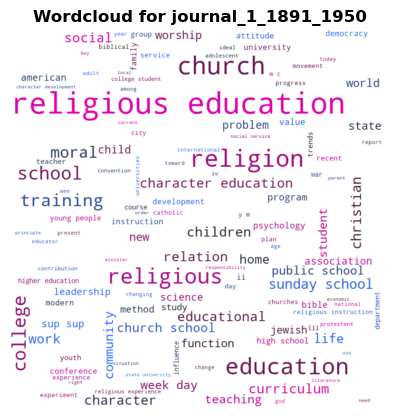

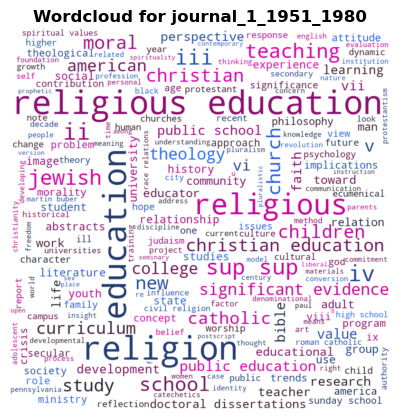

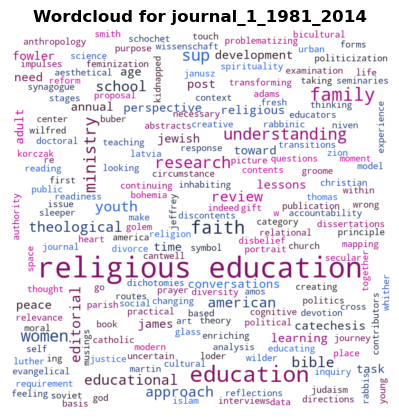

In [153]:
# Create a custom color palette representing a gradient from blue to magenta
colors = sns.diverging_palette(330, 260, s=100, l=50, n=50, center="dark", as_cmap=False)

# Create a custom color function
def custom_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return tuple(int(x * 255) for x in colors[random_state.randint(0, len(colors) - 1)])  # Convert float to integer

# Create a function to produce word clouds for each period
def generate_wordclouds_for_journal_periods(journal_i_periods):
    for period_df_name, period_df in journal_i_periods.items():
        years = period_df_name.split('_')[2:]  # Extract the years from the dataframe name
        period_text = ' '.join(period_df['better_title'].dropna().astype(str).values.flatten())

        if period_text:
            # Generate the word cloud
            wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10, color_func=custom_color_func).generate(period_text)

            # Display the word cloud
            plt.figure(figsize=(7, 4), facecolor=None)
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.title(f'Wordcloud for {period_df_name}', fontweight='bold', fontsize='large')
            plt.axis("off")
            plt.tight_layout(pad=0)
            plt.savefig(f'Wordcloud_{period_df_name}.png')
            plt.show()
        else:
            print(f"No words found for {period_df_name} ({years[0]}-{years[1]})")

generate_wordclouds_for_journal_periods({
    'journal_1_1891_1950': journal_1_1891_1950,
    'journal_1_1951_1980': journal_1_1951_1980,
    'journal_1_1981_2014': journal_1_1981_2014
})

#### 3.10.2/ Conclusions

Not the most useful output, too many common words.